# Prithvi WxC Downscaling with ECCC Data: Model Inference

This notebook is a walkthrough on using a fine-tuned downscaling model for generating inferences

We show how to initalize the model, load the `Prithvi` fine-tuned weights, and use the model for inference

To replicate the results show in this notebook please download the required files from our [Hugging Face](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling) repository

In [ ]:
from huggingface_hub import snapshot_download
import os

if not os.path.exists('granite-geospatial-wxc-downscaling'):
    snapshot_download(repo_id='ibm-granite/granite-geospatial-wxc-downscaling', allow_patterns="*", repo_type='model', local_dir='./granite-geospatial-wxc-downscaling')

**This notebook is a simple plug-and-play example** 

We provide only **1 data sample**. See `./examples/eccc_downscaling/notebooks/README.md` to download and preprocess the remaining files

---

## Setup

Python >= 3.10 is required

In [4]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import torch
import numpy as np
from itertools import product

from granitewxc.utils.config import get_config
from granitewxc.utils.eccc_data import get_dataloaders_eccc
from granitewxc.utils.plot import plot_eccc_results
from granitewxc.models.model import get_finetune_model_UNET, get_finetune_model

Pysteps configuration file found at: /dccstor/wg_ceh_dataset/victornasc/granite-wxc/.venv/lib/python3.11/site-packages/pysteps/pystepsrc



Configure the backends, PyTorch states, and random seeds to standardize the RNG for random crops in this example

In [6]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

It is possible to use a cpu or gpu/s to generate inferences. Based on avaiablity of a `cuda:gpu`, we set the device that the model uses

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Configuration File

The model is configured using `YAML` files.

In these files, you specify:
- Paths to the input data  
- Locations of the pretrained weights  

To ensure compatibility with the provided weights during inference, keep the model configuration consistent with the original definitions 

In [8]:
config_path = './granite-geospatial-wxc-downscaling/ECCC/configs/config_UNET.yaml'
config = get_config(config_path)

## Dataloader 

In this example we will use only **1 sample of data**

To download and setup all the remaining data follow the instructions in `./examples/eccc_downscaling/notebooks/README.md`

In [9]:
test_dl = get_dataloaders_eccc(config, test=True)

--> Test samples: 1


## Model Initialization

We provide **2** different model architectures `UNET-like` and `CONV` 

Both architectures include:  
1. **Patch Embedding**: Extracts shallow features from the input data  
2. **Feature Extraction**: Utilizes the Prithvi backbone to extract deeper features  

The key difference is that the UNET-like version incorporates **static high-resolution data** into the model

In this notebook, we use the **UNET-like** version

To switch to the **CONV** model, update the configuration file accordingly and use `get_finetune_model(config)`

In [10]:
model = get_finetune_model_UNET(config)

Creating the model.
--> model has 254,648,712 params.


We can now load the pretrained weights

In [11]:
weights_path = config.path_model_weights
weights = torch.load(weights_path, map_location=device)['model']

model.load_state_dict(weights, strict=True)
model.to(device)

ClimateDownscaleFinetuneUNETModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-16): 17 x Transformer(
          (drop_path): Identity()
          (attention): Sequential(
            (0): LayerNormPassThrough((1024,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=1024, out_features=3072, bias=False)
              (w_layer): Linear(in_features=1024, out_features=1024, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=1024, out_features=4096, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=4096, out_features=1024, bias=True)
                (4): Dropout(p=0.0

### Inference

The model is now ready for inference. We are running an inference for one batch (in this example batch_size=1)

Unlike training, where we used fixed-size random crops, for inference we will use the entire Canadian region, a (1280, 2528) image

In [ ]:
with torch.no_grad():
    model.eval()

    batch = next(iter(test_dl))
    batch = {k: v.to(device) for k, v in batch.items()}

    out = model(batch)

    inputs = batch['x']
    targets = batch['y']
    outputs = out

In [13]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([1, 57, 160, 316]),
 torch.Size([1, 2, 1280, 2528]),
 torch.Size([1, 2, 1280, 2528]))

### Plotting

We set the variable names and extract the sample information for generating plots

In [ ]:
var_name = "UUWE" # UUWE or VVSN
var_unit = "m/s"

output_vars = [*config.data.output_vars]
input_vars = [*config.data.input_surface_vars,
              *product(config.data.vertical_pres_vars, config.data.input_level_pres),
              *product(config.data.vertical_level1_vars, config.data.input_level1),
              *product(config.data.vertical_level2_vars, config.data.input_level2),
              *config.data.other
             ]

coarsening_factor = targets.shape[-1] / inputs.shape[-1]

f"Downscaling '{var_name}' at  by {coarsening_factor}x"

"Downscaling 'UUWE' at  by 8.0x"

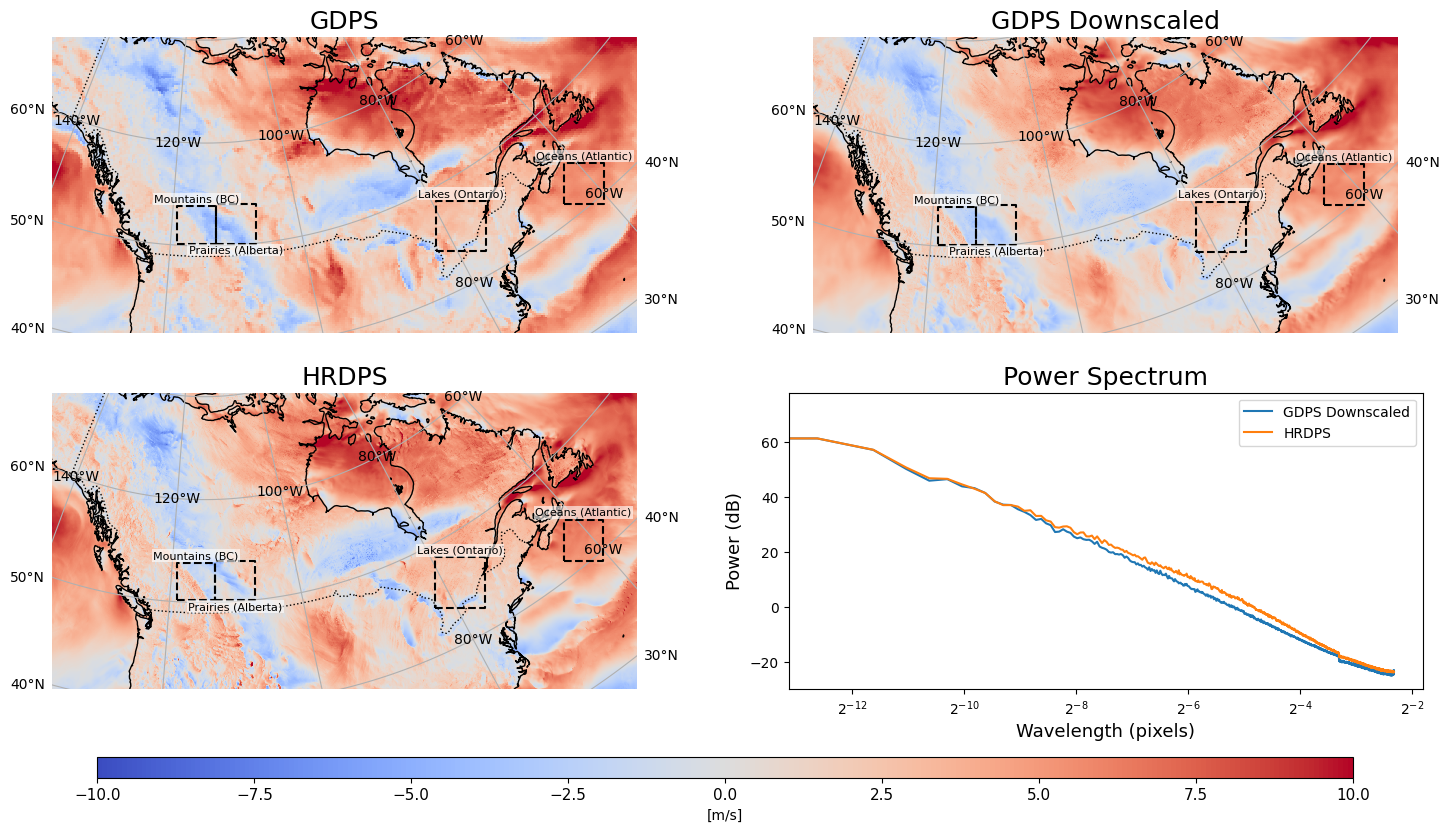

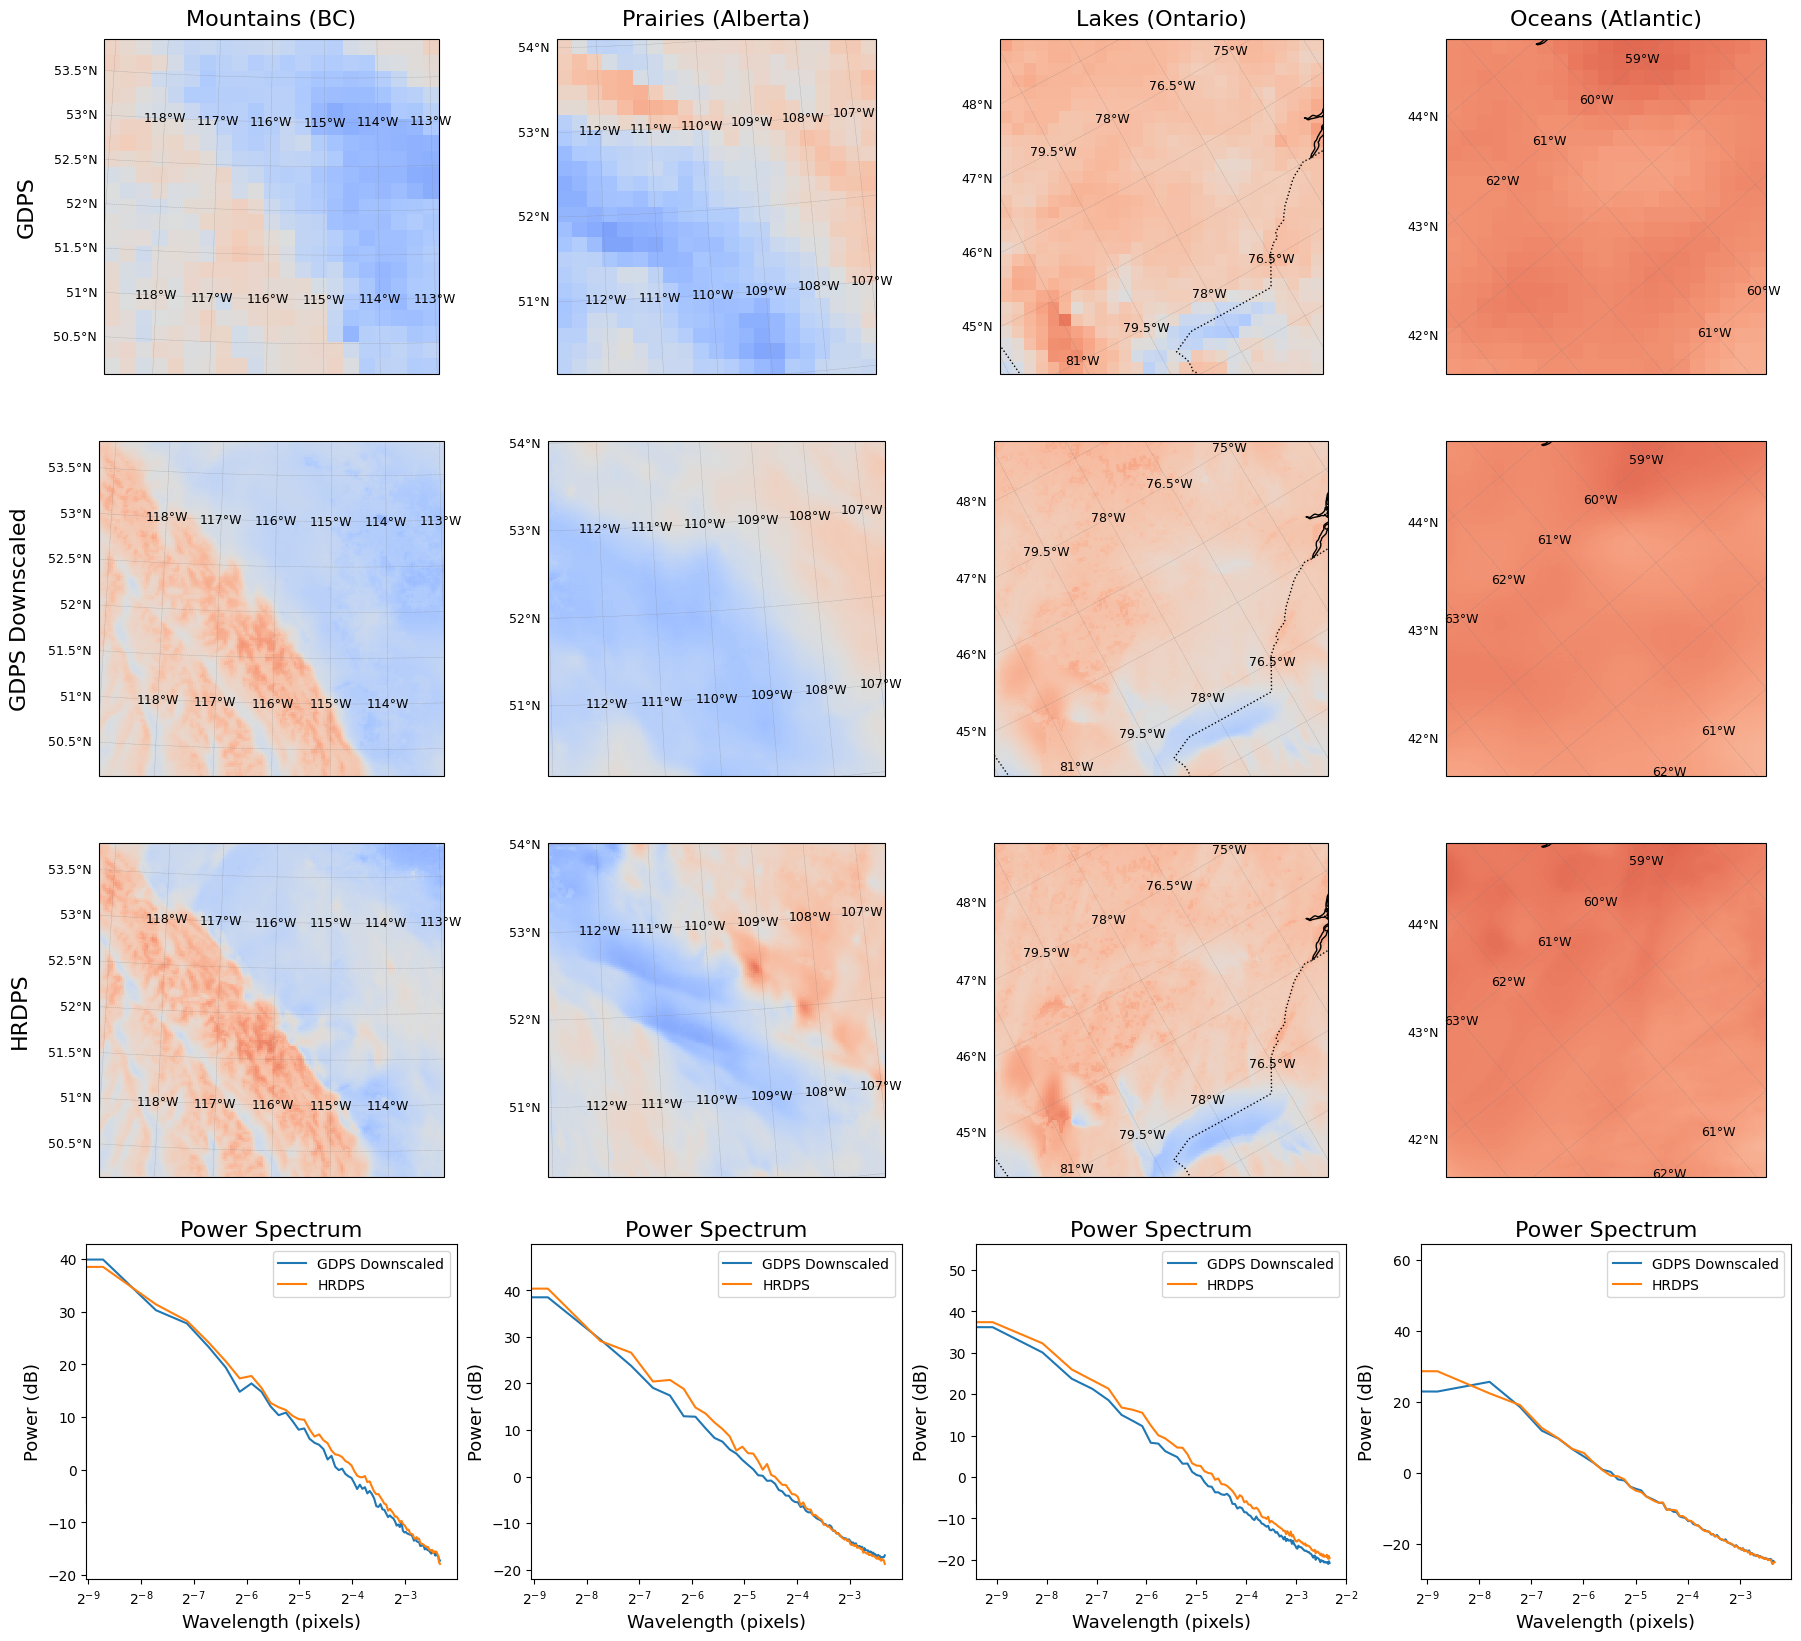

In [ ]:
for idx in range(0, len(outputs)):
    var = output_vars.index(var_name)
    input_var = input_vars.index(var_name)
    var_name_tile = var_name

    plot_input = inputs[idx, input_var, :, :].cpu().numpy()
    plot_target = targets[idx, var, : ,:].cpu().numpy()
    plot_pred = outputs[idx, var, :, :].cpu().numpy()
    plot_residual = plot_target - plot_pred

    plot_eccc_results(plot_input, plot_pred, plot_target)